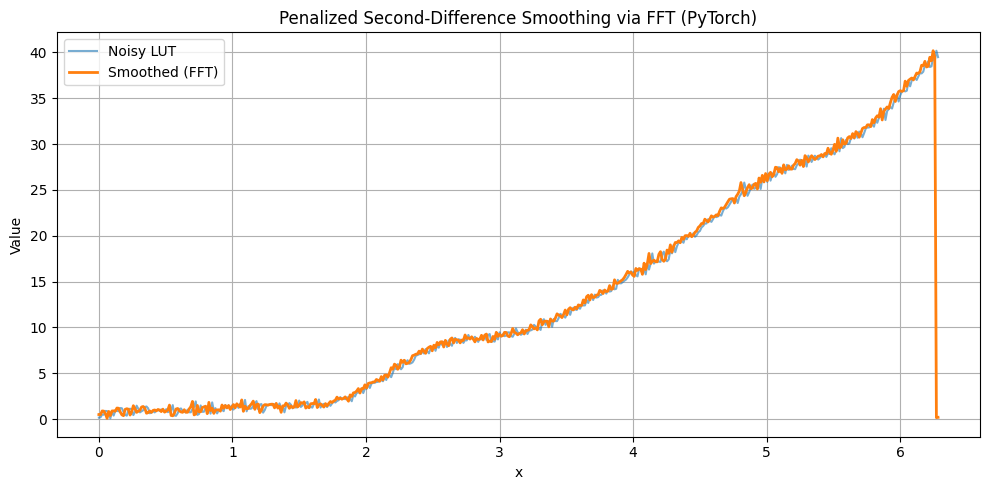

In [7]:
import torch
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Grid and data
n = 512
x = torch.linspace(0, 2 * torch.pi, n, device=device)
torch.manual_seed(0)
clean = torch.sin(3 * x) + 0.5 * torch.cos(5 * x) + x**2
y = clean + 0.3 * torch.randn_like(x)

# Penalty parameter
λ = 0.0

# Construct kernel [λ, -4λ, 1+6λ, -4λ, λ]
kernel = torch.tensor([λ, -4*λ, 1+6*λ, -4*λ, λ], device=device)
a = torch.zeros(n, device=device)
a[:5] = kernel  # aligned at index 0

# Frequency-domain solve
A_freq = torch.fft.fft(a)
Y_freq = torch.fft.fft(y)
Z_freq = Y_freq / A_freq
z_smooth = torch.fft.ifft(Z_freq).real  # final smoothed result

# Plot
x_cpu = x.cpu().numpy()
y_cpu = y.cpu().numpy()
z_cpu = z_smooth.cpu().numpy()

plt.figure(figsize=(10, 5))
plt.plot(x_cpu, y_cpu, label="Noisy LUT", alpha=0.6)
plt.plot(x_cpu, z_cpu, label="Smoothed (FFT)", linewidth=2)
plt.title("Penalized Second-Difference Smoothing via FFT (PyTorch)")
plt.xlabel("x")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


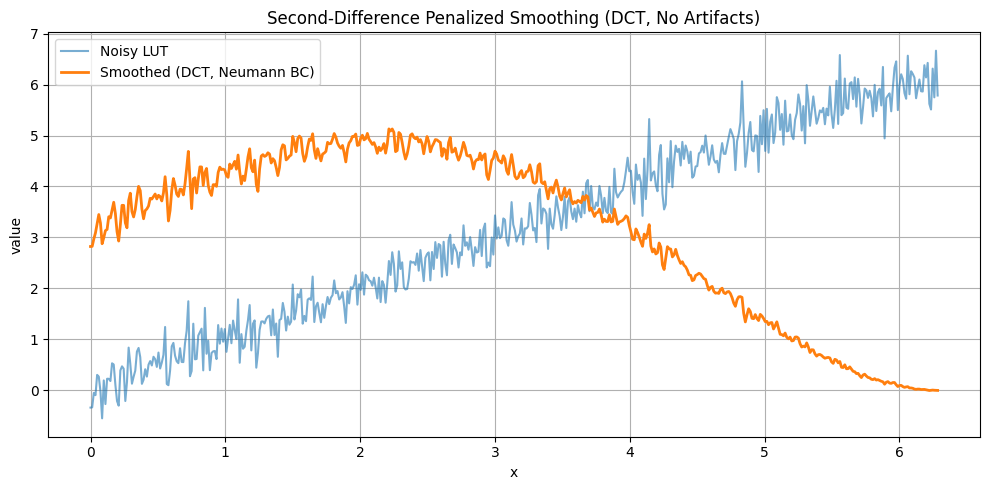

In [6]:
import torch
import matplotlib.pyplot as plt

# DCT type II (manual implementation using torch.fft)
def dct_type_2(x):
    n = x.shape[-1]
    x_ext = torch.cat([x, x.flip(dims=[-1])], dim=-1)
    X = torch.fft.fft(x_ext, dim=-1)
    return X.real[..., :n]

# Inverse DCT type II (equivalent to DCT-III)
def idct_type_2(X):
    n = X.shape[-1]
    X_ext = torch.cat([X, X.flip(dims=[-1])], dim=-1)
    x = torch.fft.ifft(X_ext, dim=-1).real
    return x[..., :n]

# DCT-based second-difference smoother
def smooth_dct(y, lam):
    n = y.shape[-1]
    k = torch.arange(n, device=y.device)
    omega = 2 * torch.sin(torch.pi * (k + 0.5) / (2 * n))
    denom = 1 + lam * omega**4
    Y = dct_type_2(y)
    Z = Y / denom
    return idct_type_2(Z)

# Generate noisy signal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n = 512
x = torch.linspace(0, 2 * torch.pi, n, device=device)
torch.manual_seed(0)
clean = x
noise = 0.3 * torch.randn(n, device=device)
y = clean + noise

# Smooth using DCT-based second-difference penalty
lam = 0.0
z_smooth = smooth_dct(y, lam)

# Move to CPU for plotting
x_cpu = x.cpu().numpy()
y_cpu = y.cpu().numpy()
z_cpu = z_smooth.cpu().numpy()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_cpu, y_cpu, label="Noisy LUT", alpha=0.6)
plt.plot(x_cpu, z_cpu, label="Smoothed (DCT, Neumann BC)", linewidth=2)
plt.title("Second-Difference Penalized Smoothing (DCT, No Artifacts)")
plt.xlabel("x")
plt.ylabel("value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


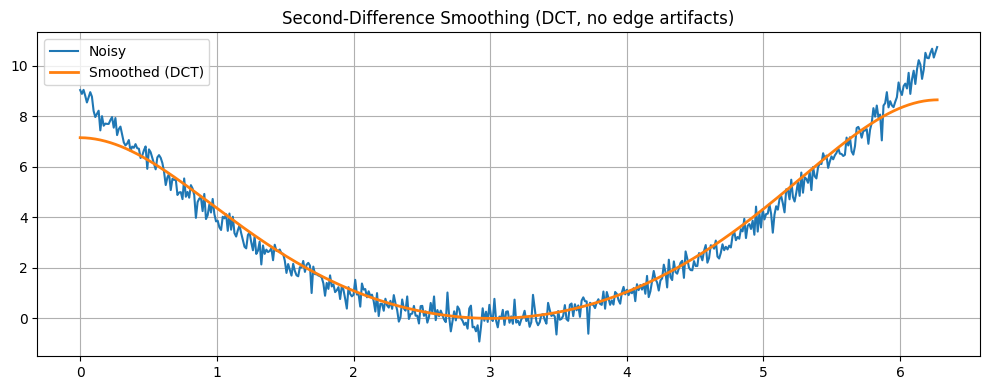

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

def smooth_dct(y, lam):
    n = y.size
    y_dct = dct(y, type=2, norm='ortho')
    k = np.arange(n)
    omega = 2 * np.sin(np.pi * (k + 0.5) / (2 * n))
    filt = 1 / (1 + lam * omega**4)
    y_dct_filtered = y_dct * filt
    return idct(y_dct_filtered, type=2, norm='ortho')

# Generate noisy signal
n = 512
x = np.linspace(0, 2 * np.pi, n, endpoint=False)
rng = np.random.default_rng(0)
# clean = np.sin(3 * x) + 0.5 * np.cos(5 * x)
clean = (x - 3)**2
y = clean + rng.normal(scale=0.3, size=n)

# Apply smoothing
lam = 1e6
z = smooth_dct(y, lam)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(x, y, label="Noisy")
plt.plot(x, z, label="Smoothed (DCT)", linewidth=2)
plt.title("Second-Difference Smoothing (DCT, no edge artifacts)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


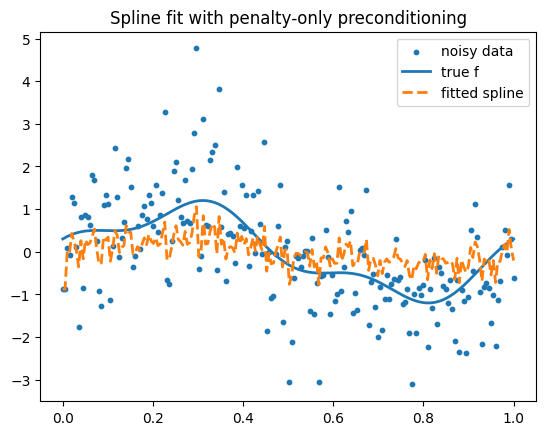

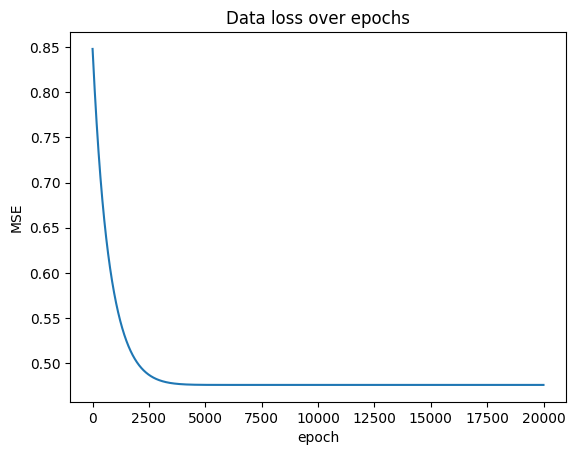

In [47]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np

# ----- 1. Synthetic data ----------------------------------------------------
torch.manual_seed(0)

n_samples = 200
x = torch.linspace(0, 1, n_samples).unsqueeze(1)            # (n, 1)

# ground‑truth smooth function
true_y = torch.sin(2 * math.pi * x) + 0.3 * torch.cos(6 * math.pi * x)

noise = 1.05 * torch.randn_like(true_y)
y = true_y + noise                                           # noisy observations

# ----- 2. B‑spline (linear hat) design matrix -------------------------------
K = 300                     # number of basis functions / knots
h = 1.0 / (K - 1)                # knot spacing
knots = torch.linspace(0, 1, K)

def hat_basis(x, t):
    """Triangular (linear) B‑spline centred at t with support 2h."""
    return torch.clamp(1 - torch.abs(x - t) / h, min=0.0)

# build full design matrix  X  (n × K)
X = torch.stack([hat_basis(x, t) for t in knots], dim=2).squeeze()

# ----- 3. Second‑difference penalty matrices --------------------------------
#  D : (K-2) × K   with rows [... 1, -2, 1, ...]
e = torch.ones(K)
D = torch.diag(e, 0)[2:] - 2 * torch.diag(e, 0)[1:-1] + torch.diag(e, 0)[:-2]
# keep only first (K-2) rows
D = D[:-2]

Kmat = D.T @ D                   # K × K  roughness Gram
lam = 1e-2                     # smoothing weight λ

# eigendecomposition  K = Q Λ Qᵀ  (dense O(K²) since K is small)
evals, Q = torch.linalg.eigh(Kmat)
scale = 1.0 / (1.0 + lam * evals)           # (I + λΛ)⁻¹  diagonal

@torch.no_grad()
def precond(g):
    """Apply P = Q(I+λΛ)⁻¹Qᵀ to gradient g."""
    return Q @ (scale * (Q.T @ g))

# ----- 4. Simple “network” : spline coefficients as parameters --------------
beta = torch.zeros(K, requires_grad=True)
optimizer = torch.optim.Adam([beta], lr=5e-2 * 1e-2)

n_epochs = 20000
history = []

for epoch in range(n_epochs):
    y_hat = X @ beta
    data_loss = 0.5 * torch.mean((y_hat - y.squeeze()) ** 2)
    pen_loss  = 0.5 * lam * torch.sum(beta[2:] ** 2)
    loss = data_loss + pen_loss

    optimizer.zero_grad()
    loss.backward()

    # penalty‑only preconditioning
    # beta.grad = precond(beta.grad)

    optimizer.step()
    history.append(data_loss.item())

# ----- 5. Plot fitted curve and training loss -------------------------------
# predicted curve
with torch.no_grad():
    y_pred = (X @ beta).detach().numpy()

# Figure 1: true function vs fitted spline
plt.figure()
plt.scatter(x.numpy(), y.numpy(), s=10, label="noisy data")
plt.plot(x.numpy(), true_y.numpy(), linewidth=2, label="true f")
plt.plot(x.numpy(), y_pred, linewidth=2, linestyle="--", label="fitted spline")
plt.title("Spline fit with penalty‑only preconditioning")
plt.legend()

# Figure 2: training loss curve
plt.figure()
plt.plot(history)
plt.title("Data loss over epochs")
plt.xlabel("epoch")
plt.ylabel("MSE")

plt.show()


In [48]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# --- hyperparameters ---
K = 100                    # number of spline coefficients
lam = 10.0                 # penalty strength
lr = 1e-2                  # learning rate
epochs = 20
batch_size = 64

# --- sample data ---
N = 10000
X_full = torch.rand(N, K)          # example B-spline design matrix
true_beta = torch.sin(torch.linspace(0, 3.14, K))  # ground truth
y_full = X_full @ true_beta + 0.1 * torch.randn(N)

# --- dataloader ---
dataset = TensorDataset(X_full, y_full)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# --- learnable spline coefficients ---
beta = nn.Parameter(torch.zeros(K))  # or use normal_() if you want

# --- penalty matrix (second differences) ---
D = -2*torch.eye(K) + torch.roll(torch.eye(K), 1, dims=0) + torch.roll(torch.eye(K), -1, dims=0)
D = D[1:-1]                           # remove first and last rows
K_pen = D.T @ D                      # shape (K, K)

# --- eigendecomposition of the penalty (once) ---
evals, Q = torch.linalg.eigh(K_pen)   # K is symmetric → safe eigendecomp
scale = 1.0 / (1.0 + lam * evals)     # diagonal preconditioner

# --- optimizer (just for API; we'll override the gradient step) ---
optimizer = torch.optim.SGD([beta], lr=lr)

# --- training loop ---
for epoch in range(epochs):
    total_loss = 0.0
    for X, y in loader:
        pred = X @ beta
        data_loss = 0.5 * (pred - y).pow(2).mean()
        penalty = 0.5 * lam * (D @ beta).pow(2).sum() / K  # mean penalty
        loss = data_loss + penalty

        optimizer.zero_grad()
        loss.backward()

        # --- precondition the gradient ---
        g = beta.grad
        g_pc = Q @ (scale * (Q.T @ g))    # diagonal preconditioner
        beta.grad = g_pc                  # overwrite gradient

        optimizer.step()
        total_loss += loss.item() * len(y)

    print(f"Epoch {epoch+1:02d} | Loss = {total_loss / N:.6f}")


Epoch 01 | Loss = 7.679807
Epoch 02 | Loss = 0.276182
Epoch 03 | Loss = 0.212702
Epoch 04 | Loss = 0.164774
Epoch 05 | Loss = 0.127613
Epoch 06 | Loss = 0.099306
Epoch 07 | Loss = 0.077503
Epoch 08 | Loss = 0.060688
Epoch 09 | Loss = 0.047664
Epoch 10 | Loss = 0.037851
Epoch 11 | Loss = 0.030273
Epoch 12 | Loss = 0.024417
Epoch 13 | Loss = 0.019896
Epoch 14 | Loss = 0.016448
Epoch 15 | Loss = 0.013789
Epoch 16 | Loss = 0.011755
Epoch 17 | Loss = 0.010187
Epoch 18 | Loss = 0.008964
Epoch 19 | Loss = 0.008045
Epoch 20 | Loss = 0.007325


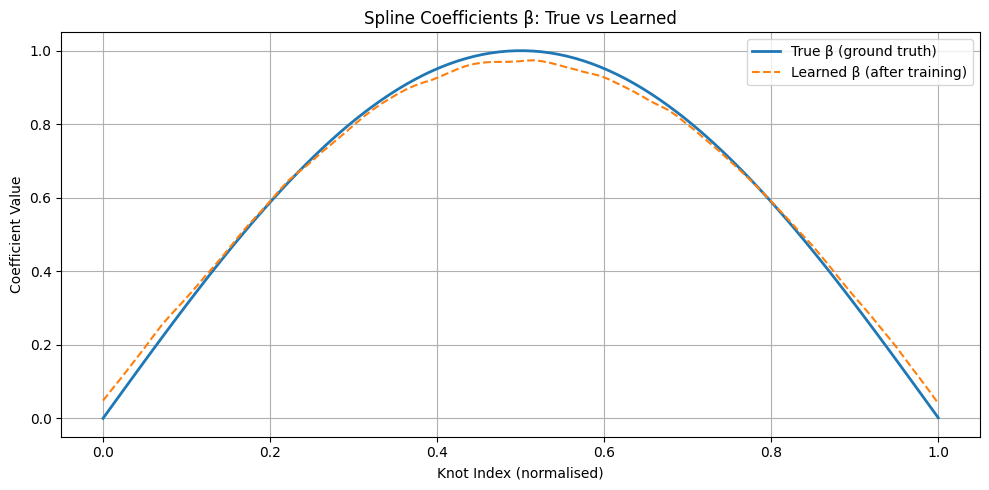

In [49]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- same setup as above ---
K = 100
lam = 10.0
lr = 1e-2
epochs = 20
batch_size = 64
torch.manual_seed(0)

# Generate synthetic data
N = 10000
X_full = torch.rand(N, K)
true_beta = torch.sin(torch.linspace(0, 3.14, K))
y_full = X_full @ true_beta + 0.1 * torch.randn(N)

# Create dataset and dataloader
dataset = torch.utils.data.TensorDataset(X_full, y_full)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Learnable parameter
beta = torch.nn.Parameter(torch.zeros(K))

# Penalty matrix D and K = D^T D
D = -2*torch.eye(K) + torch.roll(torch.eye(K), 1, dims=0) + torch.roll(torch.eye(K), -1, dims=0)
D = D[1:-1]
K_pen = D.T @ D

# Diagonalisation of penalty matrix
evals, Q = torch.linalg.eigh(K_pen)
scale = 1.0 / (1.0 + lam * evals)

# Optimizer
optimizer = torch.optim.SGD([beta], lr=lr)

# Training loop
for epoch in range(epochs):
    for X, y in loader:
        pred = X @ beta
        data_loss = 0.5 * (pred - y).pow(2).mean()
        penalty = 0.5 * lam * (D @ beta).pow(2).sum() / K
        loss = data_loss + penalty

        optimizer.zero_grad()
        loss.backward()

        # Precondition the gradient
        g = beta.grad
        g_pc = Q @ (scale * (Q.T @ g))
        beta.grad = g_pc

        optimizer.step()

# Plot the learned beta vs true
x_knots = np.linspace(0, 1, K)
plt.figure(figsize=(10, 5))
plt.plot(x_knots, true_beta.numpy(), label='True β (ground truth)', linewidth=2)
plt.plot(x_knots, beta.detach().numpy(), label='Learned β (after training)', linestyle='--')
plt.title("Spline Coefficients β: True vs Learned")
plt.xlabel("Knot Index (normalised)")
plt.ylabel("Coefficient Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


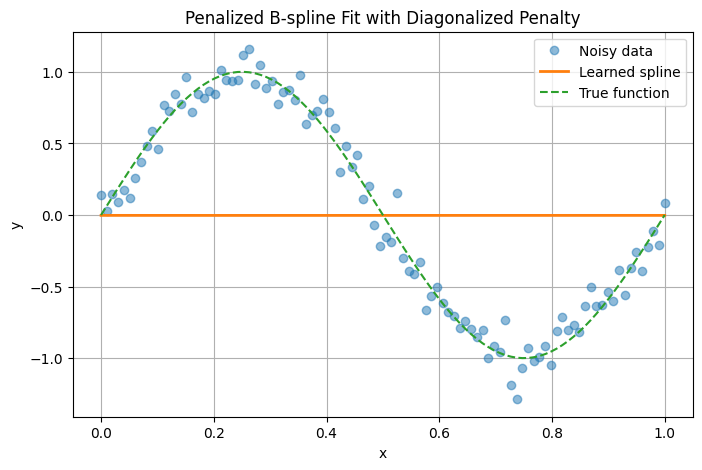

In [60]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Generate noisy training data
n = 100
x = torch.linspace(0, 1, n).view(-1, 1)
y_true = torch.sin(2 * np.pi * x)
y = y_true + 0.1 * torch.randn_like(x)

# Triangular B-spline basis
K = 50
knots = torch.linspace(0, 1, K)
X = torch.relu(1 - torch.abs(x - knots))

# Second-difference penalty matrix
D = torch.eye(K - 2, K)
D[:, 1:-1] -= 2 * torch.eye(K - 2)
D[:, 2:] += torch.eye(K - 2)
K_penalty = D.T @ D

# Diagonalize the penalty
evals, Q = torch.linalg.eigh(K_penalty)
lam = 0.0
scale = 1. / (1.0 + lam * evals)

# Learnable parameters
beta = torch.zeros(K, requires_grad=True)
optimizer = torch.optim.Adam([beta], lr=0.1)

# Training loop
for epoch in range(500):
    optimizer.zero_grad()
    y_pred = X @ beta
    loss_data = 0.5 * torch.mean((y_pred - y) ** 2)
    loss_penalty = 0.5 * lam * (beta @ K_penalty @ beta)  # correct full penalty
    loss = loss_data + loss_penalty * 0
    loss.backward()

    # Precondition the gradient
    # with torch.no_grad():
    #     g = beta.grad
    #     beta.grad = Q @ (scale * (Q.T @ g))

    optimizer.step()

# Evaluate
x_test = torch.linspace(0, 1, 500).view(-1, 1)
X_test = torch.relu(1 - torch.abs(x_test - knots))
y_test = X_test @ beta.detach()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x.numpy(), y.numpy(), 'o', label='Noisy data', alpha=0.5)
plt.plot(x_test.numpy(), y_test.numpy(), label='Learned spline', linewidth=2)
plt.plot(x.numpy(), y_true.numpy(), '--', label='True function')
plt.legend()
plt.title("Penalized B-spline Fit with Diagonalized Penalty")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


In [61]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# ---- Synthetic data ----
torch.manual_seed(0)
n = 300
x = torch.sort(torch.rand(n) * 10)[0]
y_true = torch.sin(x) + 0.3 * torch.randn(n)

# ---- B-spline basis ----
def bspline_basis(x, knots, degree=3):
    import scipy.interpolate as si
    knots_full = np.concatenate((
        [knots[0]] * degree, knots, [knots[-1]] * degree
    ))
    B = [si.BSpline.basis_element(knots_full[i:i+degree+2])(x.numpy())
         for i in range(len(knots) + degree - 1)]
    return torch.tensor(np.vstack(B).T, dtype=torch.float32)

K = 100
knots = torch.linspace(0, 10, K)
X_full = bspline_basis(x, knots)

# ---- Penalty: 2nd difference matrix ----
D = torch.eye(K)
D = D[2:] - 2 * D[1:-1] + D[:-2]  # second difference
K_penalty = D.T @ D               # (K x K)
K_diag = torch.diag(K_penalty)   # used in preconditioner

# ---- Mini-batch setup ----
batch_size = 64
loader = DataLoader(TensorDataset(X_full, y_true), batch_size=batch_size, shuffle=True)

# ---- Adam with fixed penalty preconditioner ----
beta = torch.zeros(K, requires_grad=True)
opt = torch.optim.Adam([beta], lr=0.1)
exp_avg_sq = torch.zeros(K)       # custom 2nd moment
beta_hist = []
loss_data_hist = []
loss_pen_hist = []
lambda_pen = 1.0
eps = 1e-8
beta_t = 0  # timestep

for epoch in range(100):
    for X_b, y_b in loader:
        beta_t += 1
        y_hat = X_b @ beta
        loss_data = 0.5 * (y_hat - y_b).pow(2).mean()
        loss_pen = 0.5 * lambda_pen * (beta @ K_penalty @ beta)
        loss = loss_data + loss_pen

        loss.backward()
        with torch.no_grad():
            grad = beta.grad
            exp_avg_sq = 0.9 * exp_avg_sq + 0.1 * grad.pow(2)

            # Add preconditioner: penalty diagonal
            precond = exp_avg_sq / (1 - 0.9 ** beta_t) + lambda_pen * K_diag + eps
            beta -= 0.1 * grad / precond.sqrt()

        beta.grad.zero_()

    # Save history
    beta_hist.append(beta.detach().clone())
    loss_data_hist.append(loss_data.item())
    loss_pen_hist.append(loss_pen.item())

# ---- Plotting ----
beta_final = beta.detach()
x_plot = torch.linspace(0, 10, 500)
X_plot = bspline_basis(x_plot, knots)
y_fit = X_plot @ beta_final

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.scatter(x, y_true, s=10, label="data")
plt.plot(x_plot, y_fit, 'r', label="fit")
plt.title("Penalized B-Spline Fit")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(loss_data_hist, label="Data loss")
plt.plot(loss_pen_hist, label="Penalty loss")
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()


RuntimeError: size mismatch, got input (64), mat (64x102), vec (100)

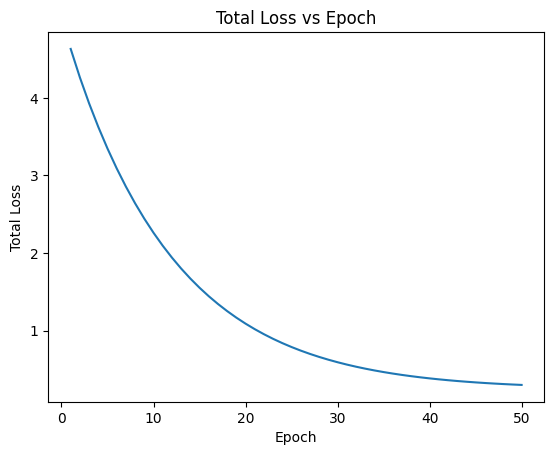

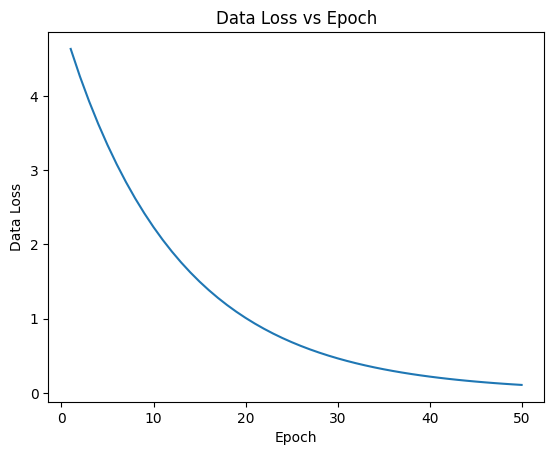

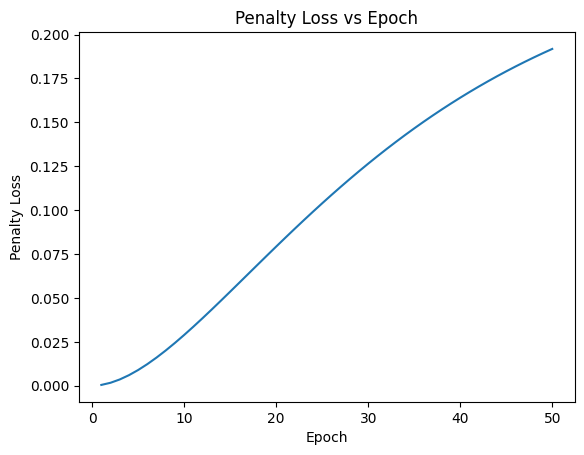

In [62]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Synthetic data generation ---
n_samples = 1000
K = 20   # Number of B-spline coefficients
X = torch.randn(n_samples, K)
beta_true = torch.sin(torch.linspace(0, 2 * np.pi, K))
y = X @ beta_true + 0.1 * torch.randn(n_samples)

# --- Penalty setup ---
# Second-difference matrix D
D = torch.zeros(K - 2, K)
for i in range(K - 2):
    D[i, i] = 1
    D[i, i + 1] = -2
    D[i, i + 2] = 1

# Penalty matrix K = D^T D and its diagonal
KT = D.t() @ D
dK = torch.diag(KT)

# --- Training hyperparameters ---
lr = 1e-2
lam = 1.0
beta2 = 0.9
eps = 1e-8
n_epochs = 50
batch_size = 100

# --- Initialization ---
beta = torch.zeros(K)
H_diag = torch.zeros(K)

loss_history = []
data_loss_history = []
penalty_loss_history = []

# --- Training loop with split preconditioner ---
for epoch in range(n_epochs):
    perm = torch.randperm(n_samples)
    for i in range(0, n_samples, batch_size):
        idx = perm[i:i + batch_size]
        Xb = X[idx]
        yb = y[idx]

        # Forward pass
        yhat = Xb @ beta
        data_loss = 0.5 * ((yhat - yb) ** 2).mean()
        penalty_loss = 0.5 * lam * (beta[2:] ** 2).mean()
        
        # Gradients
        g_data = Xb.t() @ (yhat - yb) / batch_size
        g_pen = lam * (KT @ beta)
        g_total = g_data + g_pen

        # Estimate Hessian diagonal from data
        H_batch = (Xb ** 2).sum(dim=0) / batch_size
        H_diag = beta2 * H_diag + (1 - beta2) * H_batch
        
        # Preconditioner: data + penalty
        precond = H_diag + lam * dK
        
        # Parameter update
        beta = beta - lr * g_total / (torch.sqrt(precond) + eps)

    # Record full-data losses at epoch end
    with torch.no_grad():
        yhat_full = X @ beta
        data_full = 0.5 * ((yhat_full - y) ** 2).mean().item()
        pen_full = 0.5 * lam * (beta[2:] ** 2).mean().item()
        loss_full = data_full + pen_full

    loss_history.append(loss_full)
    data_loss_history.append(data_full)
    penalty_loss_history.append(pen_full)

# --- Plotting ---
epochs = np.arange(1, n_epochs + 1)

plt.figure()
plt.plot(epochs, loss_history)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Loss vs Epoch')

plt.figure()
plt.plot(epochs, data_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Data Loss')
plt.title('Data Loss vs Epoch')

plt.figure()
plt.plot(epochs, penalty_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Penalty Loss')
plt.title('Penalty Loss vs Epoch')

plt.show()


/var/folders/jl/dyz89nlj44x37rqtffwgmrgc0000gn/T/ipykernel_21793/2328256073.py:29: RuntimeWarning: divide by zero encountered in matmul
  K = D.T @ D
/var/folders/jl/dyz89nlj44x37rqtffwgmrgc0000gn/T/ipykernel_21793/2328256073.py:29: RuntimeWarning: overflow encountered in matmul
  K = D.T @ D
/var/folders/jl/dyz89nlj44x37rqtffwgmrgc0000gn/T/ipykernel_21793/2328256073.py:29: RuntimeWarning: invalid value encountered in matmul
  K = D.T @ D
/var/folders/jl/dyz89nlj44x37rqtffwgmrgc0000gn/T/ipykernel_21793/2328256073.py:47: RuntimeWarning: divide by zero encountered in matmul
  y_pred = Xb @ beta
/var/folders/jl/dyz89nlj44x37rqtffwgmrgc0000gn/T/ipykernel_21793/2328256073.py:47: RuntimeWarning: overflow encountered in matmul
  y_pred = Xb @ beta
/var/folders/jl/dyz89nlj44x37rqtffwgmrgc0000gn/T/ipykernel_21793/2328256073.py:47: RuntimeWarning: invalid value encountered in matmul
  y_pred = Xb @ beta
/var/folders/jl/dyz89nlj44x37rqtffwgmrgc0000gn/T/ipykernel_21793/2328256073.py:48: RuntimeWar

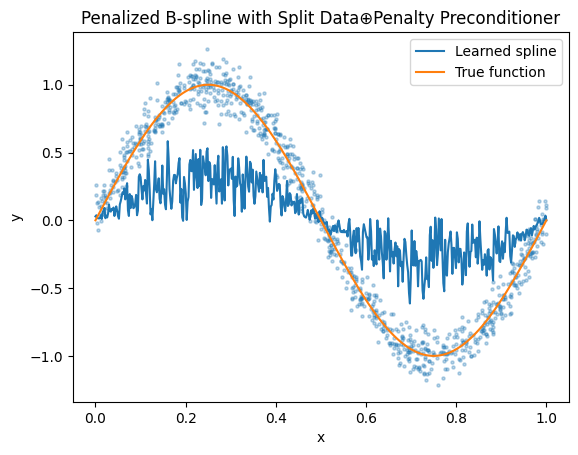

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline

# Simulate data
np.random.seed(0)
N = 1000
x = np.random.rand(N)
y = np.sin(2 * np.pi * x) + 0.1 * np.random.randn(N)

# Build B-spline basis
degree = 3
M = 2000  # number of basis functions
n_knots = M + degree + 1
internal_knots_count = n_knots - 2 * (degree + 1)
knots = np.concatenate((
    np.zeros(degree + 1),
    np.linspace(0, 1, internal_knots_count),
    np.ones(degree + 1)
))

# Design matrix
X = np.vstack([BSpline(knots, (np.arange(M) == j).astype(float), degree)(x) for j in range(M)]).T

# Penalty matrix diagonal
D = np.zeros((M-2, M))
for i in range(M-2):
    D[i, i:i+3] = [1, -2, 1]
K = D.T @ D
diag_K = np.diag(K)

# Hyperparameters and Adam state
lam = 1e-2
lr = 0.1
beta1, beta2, eps = 0.9, 0.999, 1e-8
m = np.zeros(M)
v = np.zeros(M)
beta = np.zeros(M)

# Training loop
batch_size = 100
num_iters = 2000
for t in range(1, num_iters + 1):
    idx = np.random.choice(N, batch_size, replace=False)
    Xb, yb = X[idx], y[idx]
    
    y_pred = Xb @ beta
    data_grad = (Xb.T @ (y_pred - yb)) / batch_size
    pen_grad = lam * (K @ beta)
    g = data_grad + pen_grad
    
    # Adam update with penalty Hessian diagonal added to v
    m = beta1 * m + (1 - beta1) * g
    v = beta2 * v + (1 - beta2) * (g**2 + lam * diag_K)
    
    m_hat = m / (1 - beta1**t)
    v_hat = v / (1 - beta2**t)
    
    beta -= lr * m_hat / (np.sqrt(v_hat) + eps)

# Plot learned function vs true function
x_test = np.linspace(0, 1, 500)
X_test = np.vstack([BSpline(knots, (np.arange(M) == j).astype(float), degree)(x_test) for j in range(M)]).T
y_test_pred = X_test @ beta
y_true = np.sin(2 * np.pi * x_test)

plt.figure()
plt.plot(x_test, y_test_pred, label='Learned spline')
plt.plot(x_test, y_true, label='True function')
plt.scatter(x, y, s=5, alpha=0.3)
plt.legend()
plt.title("Penalized B-spline with Split Data⊕Penalty Preconditioner")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


/var/folders/jl/dyz89nlj44x37rqtffwgmrgc0000gn/T/ipykernel_21793/1117666184.py:34: RuntimeWarning: divide by zero encountered in matmul
  K = D.T @ D
/var/folders/jl/dyz89nlj44x37rqtffwgmrgc0000gn/T/ipykernel_21793/1117666184.py:34: RuntimeWarning: overflow encountered in matmul
  K = D.T @ D
/var/folders/jl/dyz89nlj44x37rqtffwgmrgc0000gn/T/ipykernel_21793/1117666184.py:34: RuntimeWarning: invalid value encountered in matmul
  K = D.T @ D
/var/folders/jl/dyz89nlj44x37rqtffwgmrgc0000gn/T/ipykernel_21793/1117666184.py:59: RuntimeWarning: divide by zero encountered in matmul
  Zb  = (X[idx] @ W)
/var/folders/jl/dyz89nlj44x37rqtffwgmrgc0000gn/T/ipykernel_21793/1117666184.py:59: RuntimeWarning: overflow encountered in matmul
  Zb  = (X[idx] @ W)
/var/folders/jl/dyz89nlj44x37rqtffwgmrgc0000gn/T/ipykernel_21793/1117666184.py:59: RuntimeWarning: invalid value encountered in matmul
  Zb  = (X[idx] @ W)
/var/folders/jl/dyz89nlj44x37rqtffwgmrgc0000gn/T/ipykernel_21793/1117666184.py:60: RuntimeWar

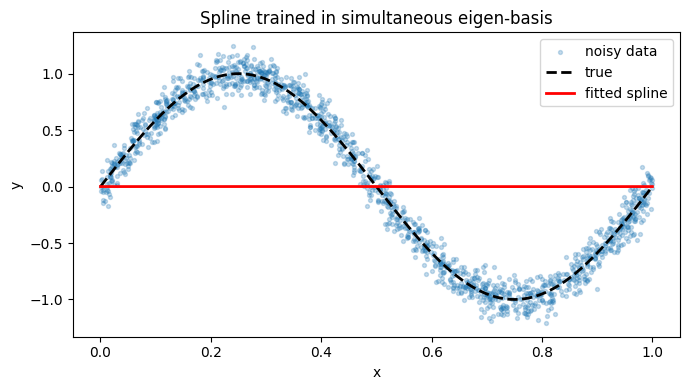

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy.linalg import cholesky, eigh

# ---- 1. Simulate data -------------------------------------------------------
np.random.seed(0)
N          = 1500
x          = np.random.rand(N)
y_true_fn  = lambda t: np.sin(2*np.pi*t)
y          = y_true_fn(x) + 0.1*np.random.randn(N)

# ---- 2. Build cubic B-spline basis -----------------------------------------
degree = 3
M      = 25
n_knots = M + degree + 1
internal_cnt = n_knots - 2*(degree+1)
knots  = np.concatenate((
    np.zeros(degree+1),
    np.linspace(0, 1, internal_cnt),
    np.ones(degree+1)
))

def design_matrix(t):
    cols = [(np.arange(M)==j).astype(float) for j in range(M)]
    return np.vstack([BSpline(knots,c,degree)(t) for c in cols]).T

X  = design_matrix(x).astype(np.float64)

# ---- 3. Penalty matrix ------------------------------------------------------
D = np.zeros((M-2, M), dtype=np.float64)
for i in range(M-2):
    D[i, i:i+3] = [1, -2, 1]
K = D.T @ D

# ---- 4. Simultaneous eigen-basis with small ridge for stability ------------
ridge = 1e-8
C  = X.T @ X + ridge*np.eye(M)
L  = cholesky(C, lower=True)
K_tilde = np.linalg.solve(L, np.linalg.solve(L.T, K).T).T
mu, U   = eigh(K_tilde)
W       = np.linalg.solve(L.T, U)
diag_mu = mu

# ---- 5. Mini-batch training -------------------------------------------------
lam     = 10.0
lr      = 0.02
beta1, beta2, eps = 0.9, 0.999, 1e-8
theta   = np.zeros(M)
m = np.zeros_like(theta)
v = np.zeros_like(theta)

batch_size = 128
num_iters = 4000
indices = np.arange(N)

for t in range(1, num_iters+1):
    idx = np.random.choice(indices, batch_size, replace=False)
    Zb  = (X[idx] @ W)
    resid = Zb @ theta - y[idx]
    g_data = (Zb.T @ resid) / batch_size
    g_pen  = lam * diag_mu * theta
    g      = g_data + g_pen

    m = beta1*m + (1-beta1)*g
    v = beta2*v + (1-beta2)*(g**2)
    m_hat = m / (1-beta1**t)
    v_hat = v / (1-beta2**t)
    theta -= lr * m_hat / (np.sqrt(v_hat) + eps)

# ---- 6. Evaluate & plot -----------------------------------------------------
beta_hat = W @ theta

x_grid = np.linspace(0,1,400)
y_pred_grid = design_matrix(x_grid) @ beta_hat

plt.figure(figsize=(7,4))
plt.scatter(x, y, s=8, alpha=0.25, label="noisy data")
plt.plot(x_grid, y_true_fn(x_grid), "k--", lw=2, label="true")
plt.plot(x_grid, y_pred_grid, "r", lw=2, label="fitted spline")
plt.legend(); plt.xlabel("x"); plt.ylabel("y")
plt.title("Spline trained in simultaneous eigen-basis")
plt.tight_layout()
plt.show()


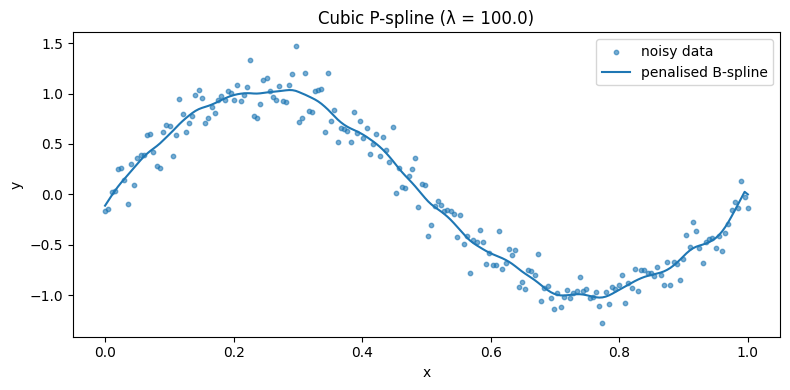

In [93]:
import torch
import matplotlib.pyplot as plt

# --------------------------
# 1.  Synthetic uniformly-spaced data
# --------------------------
torch.manual_seed(0)
n = 200
x = torch.linspace(0.0, 1.0, n)                 # uniform grid in [0,1]
y_true = torch.sin(2 * torch.pi * x)            # underlying signal
y = y_true + 0.15 * torch.randn(n)              # add noise

# --------------------------
# 2.  Cubic B-spline basis on the same grid
# --------------------------
degree = 1
num_internal_knots = 200
internal = torch.linspace(0.0, 1.0, num_internal_knots)
# replicate boundary knots (degree+1 times) for clamped splines
knots = torch.cat([
    torch.zeros(degree + 1),
    internal,
    torch.ones(degree + 1)
])

k = knots.numel() - degree - 1                  # number of basis functions

def bspline_basis(i, d, x, t):
    """ Cox-de Boor recursion for a single B-spline basis function. """
    if d == 0:
        return ((x >= t[i]) & (x < t[i + 1])).float()
    else:
        left_denom = t[i + d] - t[i]
        right_denom = t[i + d + 1] - t[i + 1]

        left = torch.zeros_like(x)
        right = torch.zeros_like(x)
        if left_denom > 0:
            left = (x - t[i]) / left_denom * bspline_basis(i, d - 1, x, t)
        if right_denom > 0:
            right = (t[i + d + 1] - x) / right_denom * bspline_basis(i + 1, d - 1, x, t)
        return left + right

# Build full design matrix B (n × k)
B_cols = [bspline_basis(i, degree, x, knots) for i in range(k)]
B = torch.stack(B_cols, dim=1)

# --------------------------
# 3.  Second-order difference penalty
# --------------------------
D = torch.zeros(k - 2, k)
for i in range(k - 2):
    D[i, i    ] = 1.0
    D[i, i + 1] = -2.0
    D[i, i + 2] = 1.0
R = D.t() @ D                                   # (k × k) roughness matrix

# --------------------------
# 4.  Penalised least-squares solution
# --------------------------
lam = 1e2                                     # smoothing parameter
BtB = B.t() @ B
lhs = BtB + lam * R
rhs = B.t() @ y
c = torch.linalg.solve(lhs, rhs)                # B-spline coefficients

y_fit = B @ c

# --------------------------
# 5.  Plot data & fitted spline
# --------------------------
plt.figure(figsize=(8, 4))
plt.scatter(x.numpy(), y.numpy(), s=10, alpha=0.6, label="noisy data")
plt.plot(x.numpy(), y_fit.detach().numpy(), label="penalised B-spline")
plt.legend()
plt.title(f"Cubic P-spline (λ = {lam})")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()


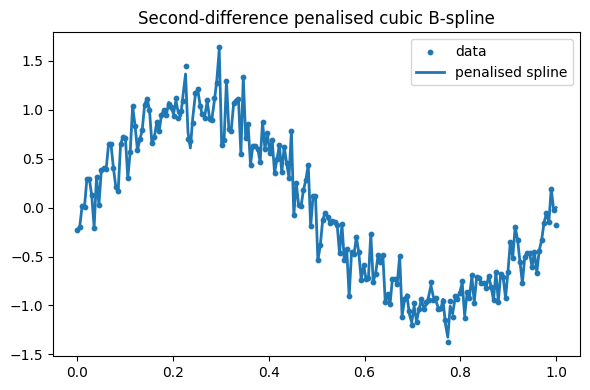

In [104]:
import torch
import torch.optim as optim
import math
import matplotlib.pyplot as plt

# -------------------------------
# 1.  Synthetic data (replace with your own)
# -------------------------------
torch.manual_seed(0)
n = 200                                  # number of points
x = torch.linspace(0.0, 1.0, n)
y = torch.sin(2 * math.pi * x) + 0.2 * torch.randn(n)   # noisy sine

# -------------------------------
# 2.  B‑spline design matrix
# -------------------------------
def bspline_basis(x: torch.Tensor, knots: torch.Tensor, degree: int = 3) -> torch.Tensor:
    """
    Evaluate all non‑zero B‑spline basis functions of the given degree
    at every position in `x` (vectorised Cox–de Boor recursion).

    Returns a matrix  (len(x) , n_basis)
    """
    x = x.unsqueeze(1)                        # (N,1)
    n_basis = knots.numel() - degree - 1

    # degree‑0 box functions
    B = []
    for i in range(n_basis):
        left = knots[i]
        right = knots[i + 1]
        B.append(((x >= left) & (x < right)).float())
    B = torch.cat(B, dim=1)                  # (N, n_basis)

    # elevate degree step‑by‑step
    for p in range(1, degree + 1):
        B_new = torch.zeros_like(B)
        for i in range(n_basis):
            # first term
            denom1 = knots[i + p] - knots[i]
            if denom1 != 0:
                B_new[:, i] += ((x.squeeze(1) - knots[i]) / denom1) * B[:, i]
            # second term
            if i + 1 < n_basis:
                denom2 = knots[i + p + 1] - knots[i + 1]
                if denom2 != 0:
                    B_new[:, i] += ((knots[i + p + 1] - x.squeeze(1)) / denom2) * B[:, i + 1]
        B = B_new
    return B

degree = 1
n_internal_knots = 200
# uniform knot vector with clamped ends
knots = torch.linspace(0.0, 1.0, n_internal_knots + 2)          # include two end knots
knots = torch.cat([knots[0:1].repeat(degree), knots, knots[-1:].repeat(degree)])
B = bspline_basis(x, knots, degree)                              # (n, k)

# -------------------------------
# 3.  Penalised spline model
# -------------------------------
coef = torch.nn.Parameter(torch.zeros(B.shape[1]))
lam = 1e-0 * 0                                                   # smoothing parameter
opt = optim.Adam([coef], lr=0.05)

for epoch in range(100):
    opt.zero_grad()
    y_pred = B @ coef
    mse = torch.mean((y - y_pred) ** 2)

    diff2 = torch.diff(coef, n=2)                                # second‑order differences
    roughness = torch.sum(diff2 ** 2)

    loss = mse + lam * roughness
    loss.backward()
    opt.step()

# -------------------------------
# 4.  Visualise the fit
# -------------------------------
plt.figure(figsize=(6, 4))
plt.scatter(x.numpy(), y.numpy(), s=10, label="data")
plt.plot(x.numpy(), (B @ coef).detach().numpy(), linewidth=2, label="penalised spline")
plt.title("Second‑difference penalised cubic B‑spline")
plt.legend()
plt.tight_layout()
plt.show()
